# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 0: Load The Data

In [1]:
import importlib
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

DEBUG = False

training_file = "data/train.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
        
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
import numpy as np
from collections import Counter

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# Shape of an traffic sign image?
image_shape = X_train.shape[1:]

# Unique classes/labels there are in the dataset.
n_classes = np.unique(np.append(y_train, y_test)).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Let's explore dataset which has been loaded.
You can find images of each class below. I didn't try to select perfect images from dataset, so that you could see diversity of the traffic sign samples and their quality. Some examples are even hardly recognizable, e.g. traffic sign with class index **19**, because of its low brightness. Not only color and scale distortions catch the eye, but a part of classes are symmetrically equal. E.g. classes **36** and **37**, if you flip one of them horizontally you will get another one class.

[  143  1695  3926  5617  7407  9315 10195 11304 12725 14177 16006 17555
 19406 21537 22784 23465 23941 24822 25995 26550 26845 27186 27555 28038
 28374 29463 30375 30729 31166 31523 31923 32594 33008 33556 34050 34994
 35655 35933 37375 38264 38603 38887 39131]


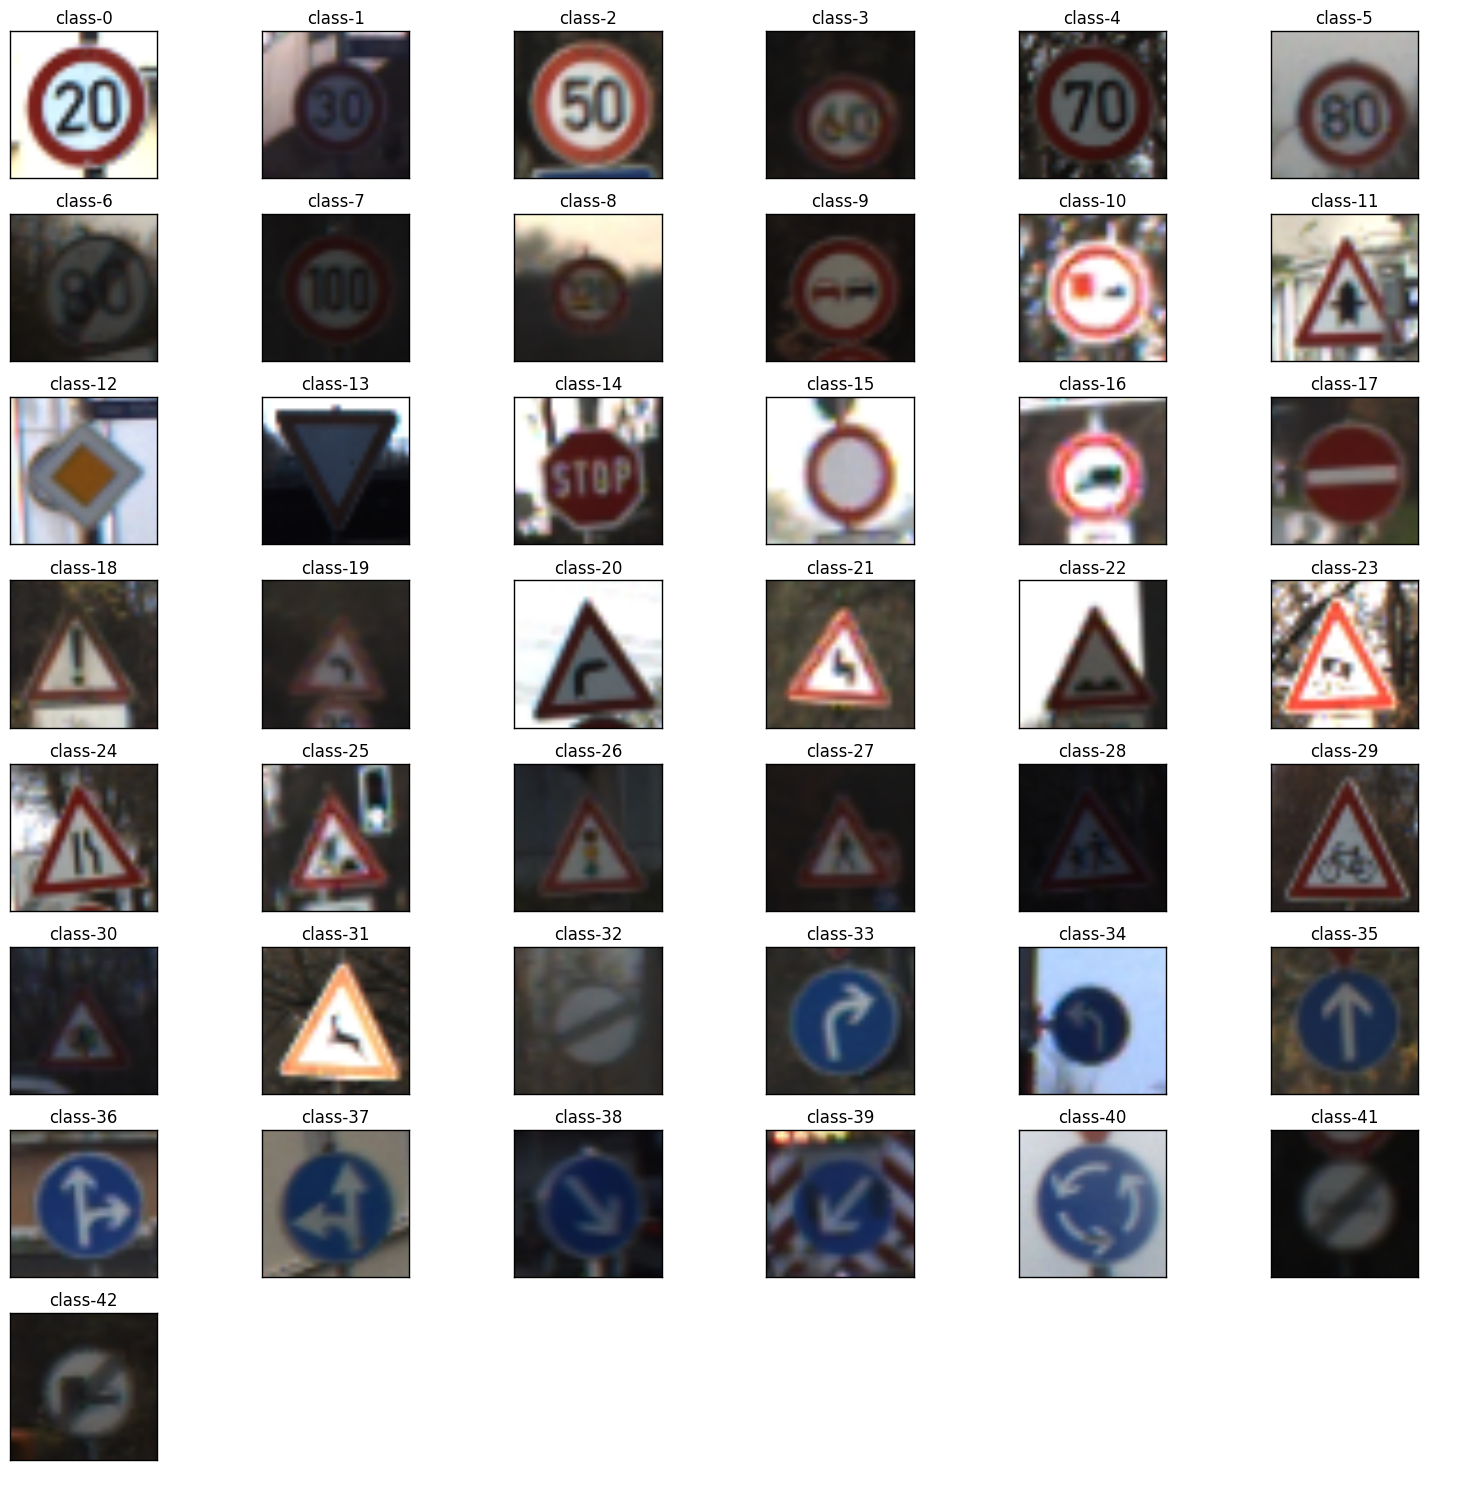

In [3]:
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

sorted_indices = np.argsort(y_train)
diff = np.diff(np.take(y_train, sorted_indices))

class_first_indices = np.append([0], np.add(np.where(diff > 0), 1))

# Last magic number is a shift of indices of the class in sorted array of indexes
# Tuning it you can find samples with better quality
class_first_indices_with_shift = class_first_indices + 10
class_indices = np.take(sorted_indices, class_first_indices_with_shift)

# We expect that number of classes in training set is equal to
# total number of classes
assert(class_indices.size == n_classes)

class_images = X_train[class_indices]
class_types = y_train[class_indices]
print(class_indices)
rows = cols = np.int(np.floor(np.sqrt(n_classes)))
rows += 2
figsize = (15, 15)

_, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
for r in np.arange(rows):
    for c in np.arange(cols):
        i = r * cols + c
        if i >= n_classes:
            axes[r][c].axis('off')
            continue
        axes[r][c].imshow(class_images[i])
        axes[r][c].set_title("class-" + str(class_types[i]))
        axes[r][c].get_xaxis().set_visible(False)
        axes[r][c].get_yaxis().set_visible(False)

plt.tight_layout()

_NOTE:_ **sorted_indices** and **class_first_indices** will be used in augumentation step. We need also write down classes which are a mirror image of each other, so that during the augumentation process we can not flip them horisontally. The **mirrow_classes** will also be used later.

In [4]:
mirror_classes = [19, 20, 33, 34, 36, 37, 38, 39]

Before start learning process, it is important to figure out the distribution of labels in training dataset. Doing so, we will be aware of skewness and bias of dataset to certain labels. Bear in mind that we keep testing dataset in the background as we will not use it during training sessions. 

In [5]:
import pandas as pd
from IPython.display import display, HTML

# Pandas sort function emits annoying warning message that columns
# argument is depricated. This trick lets shut it up.
import warnings
warnings.filterwarnings('ignore')

raw = list(Counter(y_train).items())
ds_table = pd.DataFrame(raw, columns=['class', 'count'])
ds_table = ds_table.sort(columns='count', ascending=False)
ds_table['percentage'] = ds_table['count'] / np.float32(n_train)
ds_table = ds_table.set_index(np.arange(n_classes))

pd.options.display.float_format = '{:.3f}%'.format
HTML(ds_table.to_html())

,class,count,percentage
0,2,2250,0.057%
1,1,2220,0.057%
2,13,2160,0.055%
3,12,2100,0.054%
4,38,2070,0.053%
5,10,2010,0.051%
6,4,1980,0.050%
7,5,1860,0.047%
8,25,1500,0.038%
9,9,1470,0.037%


The **histogram** shows how fla

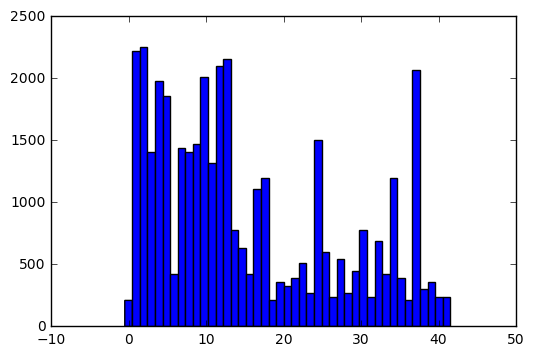

In [6]:
_, ax = plt.subplots()
_ = ax.hist(y_train, n_classes, normed=0, histtype='bar', align='left')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have 
completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

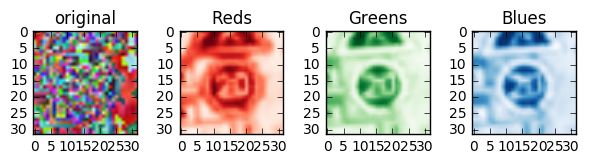

In [7]:
def immean_per_channel(img):
    return img - np.mean(img, axis=(0,1))

def imstd_per_channel(img):
    return img / np.std(img, axis=(0,1))

def norm_per_channel(img):
    copy = np.array(img, dtype=np.float32)
    return imstd_per_channel(immean_per_channel(copy))

train_image = X_train[0]
test_image = X_test[0]

train_image = np.array(train_image, dtype=np.float32)
test_image = np.array(test_image, dtype=np.float32)

norm_train_image = norm_per_channel(train_image)

print 

rmean = np.mean(norm_train_image[:,:,0])
gmean = np.mean(norm_train_image[:,:,1])
bmean = np.mean(norm_train_image[:,:,2])

cmaps = ["Reds", "Greens", "Blues"]
num_channels = len(cmaps)
_, axes = plt.subplots(ncols=num_channels+1, squeeze=True)

for i, ax in enumerate(axes):
    if i == 0:
        ax.imshow(norm_train_image)
        ax.set_title("original")
        continue
    j = i - 1
    ax.imshow(norm_train_image[:,:,j], cmap=cmaps[j])
    ax.set_title("{0}".format(cmaps[j]))

plt.tight_layout()

**Answer:**

In [8]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

import imagerich
if DEBUG:
    importlib.reload(imagerich)
from imagerich import ImageRich
import time
import numpy.random as rnd

if DEBUG:
    imgr = ImageRich(seed=0)
else:
    imgr = ImageRich()

imgr_no_flip = ImageRich(exclude=['fliplr'])

// TODO

In [9]:
jitter_class_prob = 100

class_counts = ds_table['count']
class_prob = (class_counts.size * [class_counts.max()]
              - class_counts
              + rnd.randint(jitter_class_prob, size=n_classes))
class_prob /= class_prob.sum()

// TODO

In [10]:
def __choose_image(class_id):
    """
    ```__choose_image(...)``` uses local variables created by previous steps of this notebook.
    Params
       : `class_id` - index of traffic sign
    Local variables
       : `sorted_indices`
       : `class_first_indices`
       : `X_train`
       : `y_train`
    """
    n_samples = len(sorted_indices)
    n_classes = len(class_first_indices)
    next_id = class_id + 1
    beg, end = class_id, next_id if next_id < n_classes else -1
    beg = class_first_indices[beg]
    end = class_first_indices[end] if end != -1 else n_samples - 1
    assert(beg < n_samples and end < n_samples)
    sorted_index = rnd.randint(beg, end)
    image_index = sorted_indices[sorted_index]
    assert(y_train[image_index] == class_id)
    return X_train[image_index]

def __augment_image(class_id, image):
    """
    ```__take_class_range()``` uses local variables created by previous steps of this notebook.
    Params
       : `class_id` - index of traffic sign
       : `image` - sample image
    Local variables
       : `mirror_classes`
       : `imgr`
       : `imgr_no_flip`
    """
    if class_id in mirror_classes:
        return imgr_no_flip.augment(image)
    return imgr.augment(image)

def __from_class_id_to_augmented_image(class_id):
    result = __augment_image(class_id, __choose_image(class_id))
    return result

TODO

In [11]:
# Fraction defines how many new samples should be generated comparatively original dataset
fraction = 1

# Train augmentation size
n_train_aug = n_train * fraction

# Chosen classes for augmentation
chosen_classes = rnd.choice(list(ds_table['class']), p=list(class_prob), size=n_train_aug)

image_type = type(X_train[0])
augment_func = np.vectorize(__from_class_id_to_augmented_image, otypes=[image_type])
augmented = augment_func(chosen_classes)
augmented = np.array(list(augmented))

X_train_aug, y_train_aug = augmented, np.array(chosen_classes, dtype=np.uint8)

assert(X_train_aug.shape[0] == y_train_aug.shape[0])
print("Number of augmented images: ", y_train_aug[0])

Number of augmented images:  31


TODO

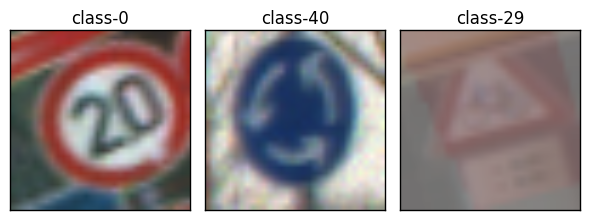

In [12]:
examples_num = 3

_, axes = plt.subplots(ncols=examples_num, squeeze=True)

for i, ax in enumerate(axes):
    ax.imshow(X_train_aug[i + 100])
    ax.set_title("class-{0}".format(y_train_aug[i + 100]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()

TODO

In [13]:
X_train_upd = np.concatenate((X_train, X_train_aug), axis=0)
y_train_upd = np.concatenate((y_train, y_train_aug), axis=0)

In [14]:
# Number of augmented training examples
n_train_upd = X_train_upd.shape[0]

print("Number of augmented training examples =", n_train_upd)

Number of augmented training examples = 78418


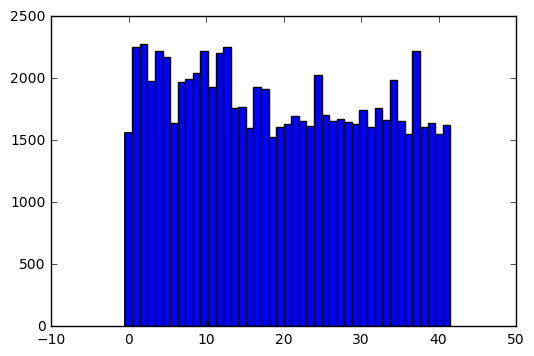

In [15]:
_, ax = plt.subplots()
_ = ax.hist(y_train_upd, n_classes, normed=0, histtype='bar', align='left')

In [16]:
raw_upd = list(Counter(y_train_upd).items())
ds_table_upd = pd.DataFrame(raw_upd, columns=['class', 'count'])
ds_table_upd = ds_table_upd.sort(columns='count', ascending=False)
ds_table_upd['percentage'] = ds_table_upd['count'] / np.float32(n_train_upd)
ds_table_upd = ds_table_upd.set_index(np.arange(n_classes))

pd.options.display.float_format = '{:.3f}%'.format
HTML(ds_table_upd.to_html())

,class,count,percentage
0,2,2280,0.029%
1,13,2253,0.029%
2,1,2252,0.029%
3,4,2224,0.028%
4,38,2222,0.028%
5,10,2221,0.028%
6,12,2202,0.028%
7,5,2176,0.028%
8,9,2040,0.026%
9,25,2031,0.026%


TODO

In [4]:
augmented_file = "data/train-augmented.p"

In [ ]:
with open(augmented_file, 'wb') as fd:
    pickle.dump({'features': X_train_upd, 'labels': y_train_upd}, fd)

TODO

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import importlib
import pickle
import time
import tensorflow as tf

In [9]:
with open(augmented_file, mode='rb') as fd:
    train_upd = pickle.load(fd)

inputs, labels = train_upd['features'], train_upd['labels']

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.